In [ ]:
# Install (pip install pycddlib )
pip install pycddlib

In [ ]:
import cdd

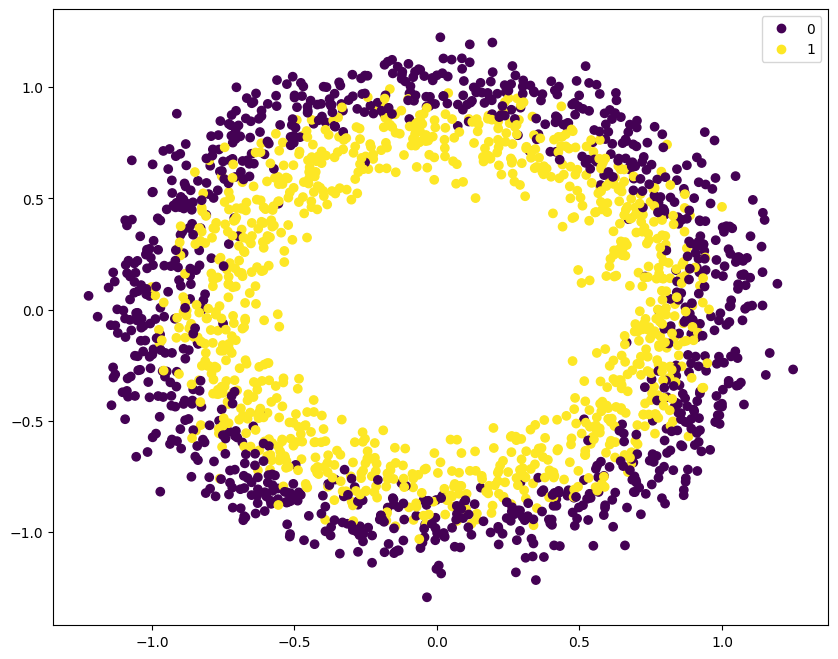

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

random_state = 0

x, y = make_circles(n_samples=2000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

plt.figure(figsize=(10,8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.legend(*scatter.legend_elements(), loc="upper right")
plt.show()

In [2]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=[4] * 1, max_iter=2000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=random_state, 
                    learning_rate_init=0.001)
mlp.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[4], max_iter=2000,
              n_iter_no_change=100, random_state=0, validation_fraction=0.2)

In [3]:
mlp.coefs_

[array([[ 1.26330575,  0.81106997,  2.28835997,  0.66100558],
        [ 0.37596265,  0.36973942, -0.85882211,  2.02183899]]),
 array([[ 0.87355974],
        [ 1.89058246],
        [-1.89513973],
        [-2.56049663]])]

In [4]:
mlp.intercepts_

[array([ 1.47921924,  0.93827836, -0.02134388, -0.4247285 ]),
 array([-0.66509044])]

In [21]:
#Aletheia weights
coefs = [np.array([[ 1.26330575,  0.81106997,  2.28835997,  0.66100558],
        [ 0.37596265,  0.36973942, -0.85882211,  2.02183899]]),
 np.array([[ 0.87355974],
        [ 1.89058246],
        [-1.89513973],
        [-2.56049663]])]

intercepts = [np.array([ 1.47921924,  0.93827836, -0.02134388, -0.4247285 ]),
 np.array([-0.66509044])]

In [22]:
# create matrix A for Activation Pattern (1,1,1,1)

In [124]:
def find_activation_region(pattern):
    # pattern is a column vector, 1 => active, 0 => inactive
    # convert to                  1 => active, -1 => inactive (to make it easier to flip equations)
    pattern = pattern * 2 - 1 # 1 -> 1, 0 -> -1
    A = -coefs[0].transpose() * pattern
    
    # additional terms in A for constraints on x1 and x2
    #x1 + 1 > 0
    #x1 - 1 < 0
    #x2 + 1 > 0
    #x2 - 1 < 0

    constraints_A = np.array([
        [-1, 0],
        [1, 0],
        [0, -1],
        [0, 1]
    ])

    A = np.vstack((A, constraints_A))
    
    # create column vector b for Activation Pattern (1,1,1,1)
    b = intercepts[0][:,np.newaxis] * pattern

    # additional terms in b for constraints on x1 and x2
    #x1 + 1 > 0
    #x1 - 1 < 0
    #x2 + 1 > 0
    #x2 - 1 < 0

    constraints_b = np.array([
        [1],
        [1],
        [1],
        [1]
    ])

    b = np.vstack((b, constraints_b))
    
    # compute H = [b - A] to represent system of inequalities,
    # and use pycddlib to solve and find verticies of resultant polytope that satisfies inequalities
    H = np.hstack((b,-A))
    

    import cdd
    mat = cdd.Matrix([[2,-1,-1,0],[0,1,0,0],[0,0,1,0]], number_type='fraction')
    mat.rep_type = cdd.RepType.INEQUALITY
    poly = cdd.Polyhedron(mat)
    #print(poly)

    mat1 = cdd.Matrix(H, number_type = 'float')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)
    #print(poly1)
    
    gen = poly1.get_generators()
    #print(gen)
    
    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    matrix = np.matrix([[gen[i][j] for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned verticies (not rays)
    assert np.all(matrix[:,0] == 1)

    # return just the verticies (not whether they are rays or not)
    return matrix[:,1:]

In [125]:
import itertools

In [126]:
perms = list(itertools.product([0,1], repeat=4))

In [127]:
matricies = []

for perm in perms:
    pattern = np.array(perm)
    #try:
    matrix = find_activation_region(np.array(perm)[:,np.newaxis])
    if matrix is None:
        print(f"could not find region for {perm}")
        continue
    matricies.append((matrix, str(perm)))
    #except Exception as e:
    #    print(f"could not find region for {perm}", e)

could not find region for (0, 0, 0, 1)
could not find region for (0, 0, 1, 0)
could not find region for (0, 0, 1, 1)
could not find region for (0, 1, 0, 0)
could not find region for (0, 1, 0, 1)
could not find region for (0, 1, 1, 0)
could not find region for (0, 1, 1, 1)
could not find region for (1, 0, 0, 1)
could not find region for (1, 0, 1, 0)
could not find region for (1, 0, 1, 1)


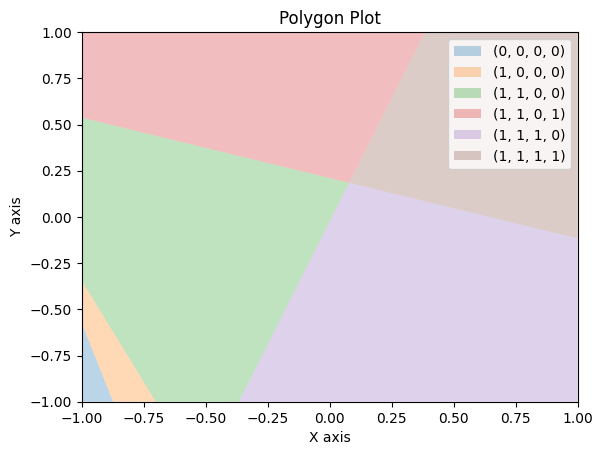

In [128]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt

for matrix, label in matricies:
    # compute the convex hull of the points
    hull = ConvexHull(matrix)

    # extract the x and y coordinates of the convex hull
    x = matrix[hull.vertices, 0]
    y = matrix[hull.vertices, 1]

    # plot and fill the polygon
    plt.fill(x, y, alpha=0.3, label=label)

# set the axis labels and title
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Polygon Plot')

# show the plot
plt.legend()
plt.show()


In [205]:
def get_constraints_layer1(pattern, coefs, intercepts):
    # pattern is a column vector, 1 => active, 0 => inactive
    # convert to                  1 => active, -1 => inactive (to make it easier to flip equations)
    pattern = pattern * 2 - 1 # 1 -> 1, 0 -> -1
    A = -coefs[0].transpose() * pattern
    
    # additional terms in A for constraints on x1 and x2
    #x1 + 1 > 0
    #x1 - 1 < 0
    #x2 + 1 > 0
    #x2 - 1 < 0

    constraints_A = np.array([
        [-1, 0],
        [1, 0],
        [0, -1],
        [0, 1]
    ])

    A = np.vstack((A, constraints_A))
    
    # create column vector b for Activation Pattern (1,1,1,1)
    b = intercepts[0][:,np.newaxis] * pattern

    # additional terms in b for constraints on x1 and x2
    #x1 + 1 > 0
    #x1 - 1 < 0
    #x2 + 1 > 0
    #x2 - 1 < 0

    constraints_b = np.array([
        [1],
        [1],
        [1],
        [1]
    ])

    b = np.vstack((b, constraints_b))
    
    return A, b

In [238]:
def find_activation_region_layer2(coefs, intercepts, pattern):
    pattern_layer1, pattern_layer2 = pattern

    # pattern is a column vector, 1 => active, 0 => inactive
    # convert to                  1 => active, -1 => inactive (to make it easier to flip equations)
    inequality_dir = pattern_layer2 * 2 - 1 # 1 -> 1, 0 -> -1
    print("inequality_dir", inequality_dir)
    
    constraints_A, constraints_b = get_constraints_layer1(pattern_layer1, coefs, intercepts)
    
    w_layer1 = coefs[0].transpose()
    w_layer2 = coefs[1].transpose()
    
    A = -w_layer2 @ (w_layer1 * pattern_layer1) * inequality_dir
    print("A.shape", A.shape)
    print("A", A)
    
    A = np.vstack((A, constraints_A))
    
    b_layer1 = intercepts[0][:,np.newaxis]
    b_layer2 = intercepts[1][:,np.newaxis]
    b = (w_layer2 @ (b_layer1 * pattern_layer1) + b_layer2) * inequality_dir
    print("b.shape", b.shape)
    print("b", b)

    b = np.vstack((b, constraints_b))
    
    #import pdb; pdb.set_trace()
    
    # compute H = [b - A] to represent system of inequalities,
    # and use pycddlib to solve and find verticies of resultant polytope that satisfies inequalities
    H = np.hstack((b,-A))
    

    mat1 = cdd.Matrix(H, number_type = 'float')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)
    print("H matrix", poly1)
    
    gen = poly1.get_generators()
    print(gen)
    print("V matrix", gen)

    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    matrix = np.matrix([[gen[i][j] for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned verticies (not rays)
    assert np.all(matrix[:,0] == 1)

    # return just the verticies (not whether they are rays or not)
    return matrix[:,1:]

In [239]:
import itertools

In [240]:
perms

[(0,), (1,)]

In [241]:
matricies = []

# todo filter to just the activation patterns that have non-zero area
perms_layer1 = list(itertools.product([0,1], repeat=4))
perms_layer2 = list(itertools.product([0,1], repeat=1))

for perm1 in perms_layer1:
    pattern_layer1 = np.array(perm1)[:,np.newaxis]

    for perm2 in perms_layer2:
        print(f"=== pattern {perm1, perm2} ===")
        pattern_layer2 = np.array(perm2)[:,np.newaxis]
        pattern = (pattern_layer1, pattern_layer2)
        matrix = find_activation_region_layer2(coefs, intercepts, pattern)
        if matrix is None:
            print(f"could not find region for {perm1, perm2}")
            continue
        matricies.append((matrix, str((perm1, perm2))))

=== pattern ((0, 0, 0, 0), (0,)) ===
inequality_dir [[-1]]
A.shape (1, 2)
A [[-0. -0.]]
b.shape (1, 1)
b [[0.66509044]]
H matrix begin
 9 3 real
  6.650904400E-01  0  0
 -1.479219240E+00 -1.263305750E+00 -3.759626500E-01
 -9.382783600E-01 -8.110699700E-01 -3.697394200E-01
  2.134388000E-02 -2.288359970E+00  8.588221100E-01
  4.247285000E-01 -6.610055800E-01 -2.021838990E+00
  1  1  0
  1 -1  0
  1  0  1
  1  0 -1
end
V-representation
begin
 3 3 real
  1 -8.733092444E-01 -1
  1 -1 -5.742950530E-01
  1 -1 -1
end
V matrix V-representation
begin
 3 3 real
  1 -8.733092444E-01 -1
  1 -1 -5.742950530E-01
  1 -1 -1
end
=== pattern ((0, 0, 0, 0), (1,)) ===
inequality_dir [[1]]
A.shape (1, 2)
A [[0. 0.]]
b.shape (1, 1)
b [[-0.66509044]]
H matrix begin
 9 3 real
 -6.650904400E-01  0  0
 -1.479219240E+00 -1.263305750E+00 -3.759626500E-01
 -9.382783600E-01 -8.110699700E-01 -3.697394200E-01
  2.134388000E-02 -2.288359970E+00  8.588221100E-01
  4.247285000E-01 -6.610055800E-01 -2.021838990E+00
  1  

In [242]:
matricies

[(matrix([[-0.87330924, -1.        ],
          [-1.        , -0.57429505],
          [-1.        , -1.        ]]),
  '((0, 0, 0, 0), (0,))'),
 (matrix([[-1.        , -0.34404876],
          [-0.70097397, -1.        ],
          [-0.87330924, -1.        ],
          [-1.        , -0.57429505]]),
  '((1, 0, 0, 0), (0,))'),
 (matrix([[-0.70097397, -1.        ],
          [-0.52087853, -1.        ],
          [-1.        , -0.34404876],
          [-1.        ,  0.22967488]]),
  '((1, 1, 0, 0), (0,))'),
 (matrix([[-0.36597312, -1.        ],
          [ 0.07853103,  0.18439602],
          [-1.        ,  0.53700324],
          [-0.52087853, -1.        ],
          [-1.        ,  0.22967488]]),
  '((1, 1, 0, 0), (1,))'),
 (matrix([[ 0.38462742,  1.        ],
          [ 0.35518774,  0.921557  ],
          [-1.        ,  0.61310082],
          [-1.        ,  1.        ]]),
  '((1, 1, 0, 1), (0,))'),
 (matrix([[ 0.07853103,  0.18439602],
          [-1.        ,  0.53700324],
          [ 0.35518

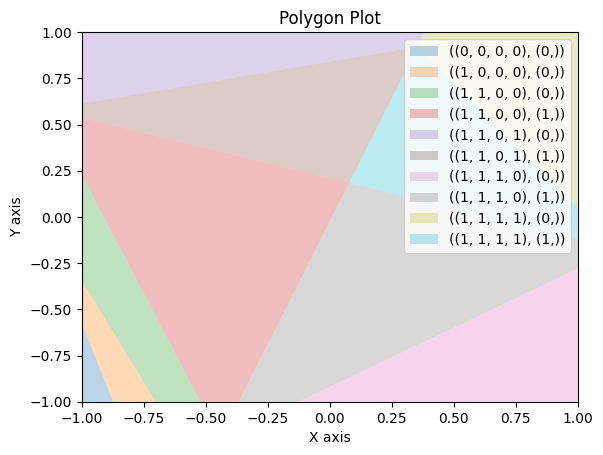

In [243]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt

for matrix, label in matricies:
    # compute the convex hull of the points
    hull = ConvexHull(matrix)

    # extract the x and y coordinates of the convex hull
    x = matrix[hull.vertices, 0]
    y = matrix[hull.vertices, 1]

    # plot and fill the polygon
    plt.fill(x, y, alpha=0.3, label=label)

# set the axis labels and title
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Polygon Plot')

# show the plot
plt.legend()
plt.show()
